# Nifty50 Price Prediction

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import time
import tensorflow.keras.callbacks as keras_callbacks

In [3]:
data = pd.read_csv(r'/content/Nifty_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

<ipython-input-3-1b49d7eea2ce>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Date'] = pd.to_datetime(data['Date'])


In [4]:
data.head()

,Date.1,Date.2,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-21,6085.750000,6094.350098,6065.100098,6082.299805,6082.299805,130900.0
2013-01-22,6080.149902,6101.299805,6040.500000,6048.500000,6048.500000,129000.0
2013-01-23,6052.850098,6069.799805,6021.149902,6054.299805,6054.299805,137000.0
2013-01-24,6046.200195,6065.299805,6007.850098,6019.350098,6019.350098,185200.0
2013-01-25,6024.500000,6080.549805,6014.450195,6074.649902,6074.649902,147600.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2761 entries, 2013-01-21 to 2024-03-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date.1     2747 non-null   float64
 1   Date.2     2747 non-null   float64
 2   Low        2747 non-null   float64
 3   Close      2747 non-null   float64
 4   Adj Close  2747 non-null   float64
 5   Volume     2747 non-null   float64
dtypes: float64(6)
memory usage: 151.0 KB


In [6]:
data.isnull().sum()

Date.1       14
Date.2       14
Low          14
Close        14
Adj Close    14
Volume       14
dtype: int64

In [9]:
data.dropna(inplace=True)

In [10]:
data.isnull().sum()

Date.1       0
Date.2       0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
data.describe()

,Date.1,Date.2,Low,Close,Adj Close,Volume
count,2747.000000,2747.000000,2747.000000,2747.000000,2747.000000,2.747000e+03
mean,11620.584749,11675.119677,11546.628547,11612.470028,11612.470028,2.959153e+05
std,4386.267802,4401.376556,4364.827173,4385.116764,4385.116764,1.928774e+05
min,5233.450195,5317.700195,5118.850098,5285.000000,5285.000000,0.000000e+00
25%,8214.175293,8250.799805,8154.600098,8216.375000,8216.375000,1.690000e+05
50%,10596.200200,10631.650390,10532.700200,10584.700200,10584.700200,2.338000e+05
75%,15696.899905,15753.399905,15592.524905,15688.375005,15688.375005,3.522500e+05
max,22517.500000,22526.599610,22430.000000,22493.550780,22493.550780,1.811000e+06


In [14]:
mean_volume = data.loc[data['Volume'] != 0, 'Volume'].mean()

# Replace 0 values with the calculated mean
data.loc[data['Volume'] == 0, 'Volume'] = mean_volume

In [15]:
data.describe()

,Date.1,Date.2,Low,Close,Adj Close,Volume
count,2747.000000,2747.000000,2747.000000,2747.000000,2747.000000,2.747000e+03
mean,11620.584749,11675.119677,11546.628547,11612.470028,11612.470028,2.985234e+05
std,4386.267802,4401.376556,4364.827173,4385.116764,4385.116764,1.908655e+05
min,5233.450195,5317.700195,5118.850098,5285.000000,5285.000000,1.000000e+02
25%,8214.175293,8250.799805,8154.600098,8216.375000,8216.375000,1.715000e+05
50%,10596.200200,10631.650390,10532.700200,10584.700200,10584.700200,2.371000e+05
75%,15696.899905,15753.399905,15592.524905,15688.375005,15688.375005,3.522500e+05
max,22517.500000,22526.599610,22430.000000,22493.550780,22493.550780,1.811000e+06


In [16]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [17]:
# Split data into train and test sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

In [18]:
# Generate sequences 
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


In [21]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Define callbacks
callbacks = [
    keras_callbacks.EarlyStopping(monitor='val_loss', patience=10),
    keras_callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
]

# Train model
start_time = time.time()
history = model.fit(X_train, y_train, epochs=10, batch_size=200, validation_split=0.05, verbose=2, callbacks=callbacks)
end_time = time.time()
print("Total time taken for training: {:.2f} seconds".format(end_time - start_time))


Epoch 1/10
11/11 - 6s - loss: 0.0135 - val_loss: 0.0036 - 6s/epoch - 540ms/step
Epoch 2/10
11/11 - 0s - loss: 0.0023 - val_loss: 0.0189 - 346ms/epoch - 31ms/step
Epoch 3/10
11/11 - 0s - loss: 8.5821e-04 - val_loss: 0.0018 - 364ms/epoch - 33ms/step
Epoch 4/10
11/11 - 0s - loss: 3.8892e-04 - val_loss: 0.0025 - 350ms/epoch - 32ms/step
Epoch 5/10
11/11 - 0s - loss: 1.9349e-04 - val_loss: 5.7890e-04 - 348ms/epoch - 32ms/step
Epoch 6/10
11/11 - 0s - loss: 1.6011e-04 - val_loss: 2.8319e-04 - 355ms/epoch - 32ms/step
Epoch 7/10
11/11 - 0s - loss: 1.4979e-04 - val_loss: 4.1580e-04 - 345ms/epoch - 31ms/step
Epoch 8/10
11/11 - 0s - loss: 1.4294e-04 - val_loss: 3.6699e-04 - 331ms/epoch - 30ms/step
Epoch 9/10
11/11 - 0s - loss: 1.4094e-04 - val_loss: 3.5033e-04 - 346ms/epoch - 31ms/step
Epoch 10/10
11/11 - 0s - loss: 1.4064e-04 - val_loss: 4.3439e-04 - 327ms/epoch - 30ms/step
Total time taken for training: 9.19 seconds


In [22]:
# Evaluate model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, train_predict)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_predict)))

17/17 [==============================] - 0s 5ms/step
Train RMSE: 0.012432459009944042
Test RMSE: 0.03380275800369183


In [23]:
predictions = model.predict(X_test)

17/17 [==============================] - 0s 5ms/step


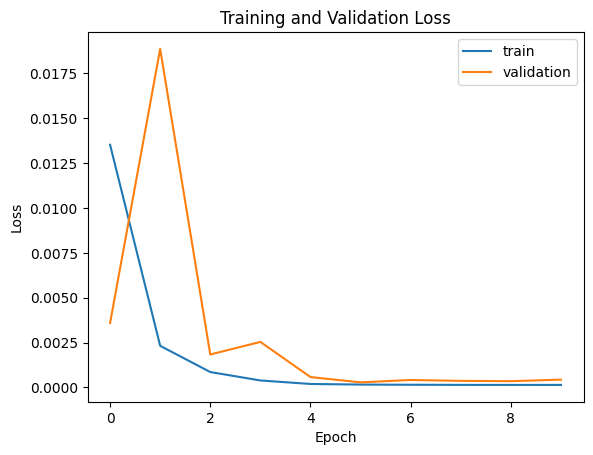

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

17/17 [==============================] - 0s 4ms/step


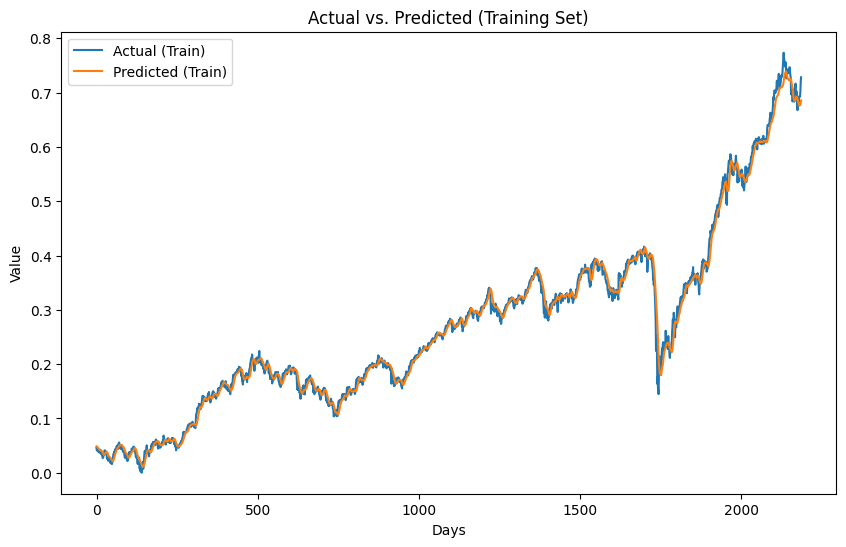

In [28]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual (Train)')
plt.plot(train_predictions, label='Predicted (Train)')
plt.xlabel('Days')
plt.ylabel('Value')
plt.title('Actual vs. Predicted (Training Set)')
plt.legend()
plt.show()

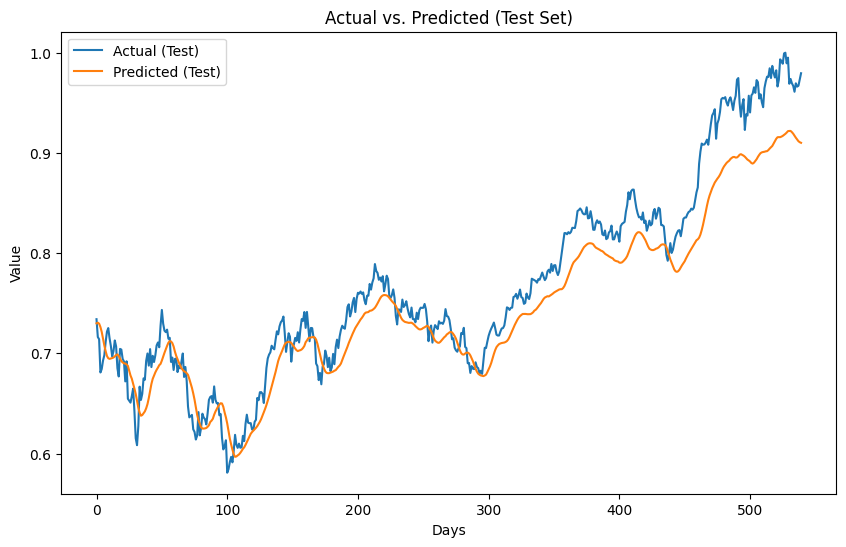

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual (Test)')
plt.plot(test_predictions, label='Predicted (Test)')
plt.xlabel('Days')
plt.ylabel('Value')
plt.title('Actual vs. Predicted (Test Set)')
plt.legend()
plt.show()

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)


Train RMSE: 0.012432459009944042
Test RMSE: 0.03380275800369183
